# Machine Learning Demonstrations

In this notebook, we demonstrated how to use the Kx kdb+/q Automated Machine Learning library. The example below use samples from the Telco Customer Churn dataset and IMBD movie review dataset.

<div class="alert alert-danger">
To run the below notebook, ensure that dependencies specified in <b>requirements.txt</b> have been correctly installed.
</div>

## Machine Learning Toolkit

The Machine Learning Toolkit ([ML-Toolkit](https://github.com/KxSystems/ml)) contains general use utilities, an implementation of the FRESH (Feature Extraction based on Scalable Hypothesis tests) algorithm, cross validation functions, clustering libraries and time series functionality. The primary purpose of these libraries are to provide kdb+/q users with access to commonly-used ML functions for preprocessing data, extracting features and scoring results.

## Automated Machine Learning in kdb+/q

The kdb+/q [Automated Machine Learning](https://github.com/kxsystems/automl/) library is built largely on the tools available within the kdb+/q ML-Toolkit. The purpose of this library is to provide users with the ability to automate the process of applying machine learning techniques to real-world problems. In the absence of expert machine learning engineers this framework handles the following processes within a traditional workflow:

- Data preprocessing
- Feature engineering and feature selection
- Model selection
- Hyperparameter Tuning
- Report generation and model persistence

Each of these steps is outlined in depth within the documentation for this platform [here](https://code.kx.com/q/ml/automl). This allows users to understand the processes by which decisions are being made and the transformations which their data undergo during the production of the output models.

At present the supported machine learning problem types are classification and regression and based on:

- One-to-one feature to target non time-series
- FRESH based feature extraction and model production
- NLP-based feature creation and word2vec transformation

The problems which can be solved by this framework will be expanded over time as will the available functionality.

### Multi-processing

This library supports multi-processed grid-search/cross-validation procedures and FRESH feature creation provided a user set `-s -8` in the JUPYTERQ_SERVERARGS, access to which can be found [here](https://code.kx.com/q/ml/jupyterq/notebooks/#server-command-line-arguments). In this demo, we use 8 worker processes and open a centralised port as below.

In [1]:
\p 5124

The Kx Automated Machine Learning library is then loaded in as follows:

In [2]:
// load in automl
\l automl/automl.q
.automl.loadfile`:init.q

// load utils
\l ../utils/util.q
\l ../utils/graphics.q


Documentation can be found at https://code.kx.com/q/ml/automl/


---

## Contents

Below, the notebook has been split into 3 distinct sections:
1. [Default Configurations](#Default-Configurations)
2. [Default NLP Configurations](#Default-NLP-Configurations)
3. [Custom Configurations (Advanced)](#Custom-Configurations-(Advanced))

---

### Telco Customer Churn

The [Telco Customer Churn dataset](https://www.kaggle.com/blastchar/telco-customer-churn/data) contains entries for 7043 customers. In each case below, we aim to create a model which can accurately predict customer churn based on 20 features relating to each customer.

Below we load in the data and select a subset of 5000 random data points to train and test the pipeline on.

### Load data

In [3]:
\S 42

// load data and separate into features and target
telcoData:5000?("SSBSSISSSSSSSSSSSSFFS";(),",")0:`:../data/telco.csv
telcoTarg:(`No`Yes!0 1)telcoData`Churn
telcoFeat:delete Churn from telcoData

// inspect data
-1"Shape of feature data is: ",(" x "sv string .ml.shape telcoFeat),"\n";
show 5#telcoFeat
-1"\nDistribution of target values:\n";
show update pcnt:.util.round[;.01]100*num%sum num from select num:count i by target from([]target:telcoTarg);

Shape of feature data is: 5000 x 20

customerID gender SeniorCitizen Partner Dependents tenure PhoneService Multip..
-----------------------------------------------------------------------------..
5382-TEMLV Male   0             No      No         45     Yes          No    ..
5827-MWCZK Male   0             Yes     Yes        56     Yes          Yes   ..
3086-RUCRN Female 0             No      No         66     Yes          Yes   ..
5965-GGPRW Male   0             Yes     Yes        72     Yes          Yes   ..
2887-JPYLU Female 0             No      Yes        41     Yes          No    ..

Distribution of target values:

target| num  pcnt 
------| ----------
0     | 3637 72.74
1     | 1363 27.26


### Prepare data

We start by splitting our data into a training and testing set, where 10% has been chosen for the testing set. The training data will be used to fit a best model for the dataset using `.automl.fit`, while the testing set will be used to analyze how well the model preforms on unseen data.

Note that we have set a random seed so that results can be replicated.

In [4]:
\S 42
show telcoInputs:.ml.traintestsplit[telcoFeat;telcoTarg;.1]

xtrain| +`customerID`gender`SeniorCitizen`Partner`Dependents`tenure`PhoneServ..
ytrain| 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0..
xtest | +`customerID`gender`SeniorCitizen`Partner`Dependents`tenure`PhoneServ..
ytest | 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0..


## Default Configurations

### Inputs

The automated machine learning pipeline will be used to the training feature (`xtrain`) and target (`ytrain`) Churn data using `automl.fit`. Appropriate preprocessing steps including feature creation and selection will be applied to the data before being passed to a variety of machine learning models, choosing the best performing model. 

In this case, we select ``` `normal``` feature extraction as we have a 1-to-1 mapping between features and targets. We also use ``` `class``` for the problem type as we are dealing with a binary classification problem.

**NB:** For the purposes of this demonstration we will pass in a dictionary in place of the default parameter `(::)`. In order to ensure replication for users of this notebook the random seed parameter ``` `seed``` is set in this example with the remaining parameters defaulted.

In [5]:
telcoFeats  :telcoInputs`xtrain       / features
telcoTarget :telcoInputs`ytrain       / targets
featureType1:`normal                  / normal feature extraction
problemType1:`class                   / classification problem
paramDict1  :enlist[`seed]!enlist 350 / default configuration

In the default configuration, information obtained during the process will we saved to the outputs folder. This includes meta information, graphs, reports and a fitted model.

In addition to the saved outputs, the function will also return `modelInfo`  containing meta information generated from the pipeline such as preprocessing steps taken, significant features chosen and any other information needed to replicate the results.

Predictions can be made on the testing data using the `predict` attribute returned by the process. This applies the best model created during the pipeline to new data after any neccessary preprocessing and feature creation steps are taken.

We can now run `.automl.fit` using the default setting with out training set from the Telco Customer Churn dataset.

In [6]:
start:.z.t
model1:.automl.fit[telcoFeats;telcoTarget;featureType1;problemType1;paramDict1]
-1"\n.automl.fit took ",string .z.t-start;

Executing node: automlConfig
Executing node: configuration
Executing node: targetDataConfig
Executing node: targetData
Executing node: featureDataConfig
Executing node: featureData
Executing node: dataCheck
Executing node: featureDescription

The following is a breakdown of information for each of the relevant columns in the dataset


                | count unique mean     std      min   max     type       
------          | --------------------------------------------------------
tenure          | 4500  73     32.326   24.55931 0i    72i     numeric    
MonthlyCharges  | 4500  1251   64.88498 30.49795 18.55 118.75  numeric    
TotalCharges    | 4500  3178   2284.252 2275.078 18.85 8672.45 numeric    
customerID      | 4500  3310   ::       ::       ::    ::      categorical
gender          | 4500  2      ::       ::       ::    ::      categorical
Partner         | 4500  2      ::       ::       ::    ::      categorical
Dependents      | 4500  2      ::       ::       ::    ::      

#### Feature impact

<img src="images/run1impact.png" />

We see that in the above example, 8 features were passed to the model following the application of feature extraction and significance testing. 

**NB:** In the default case, normal feature extraction only uses the original features passed into the system, while FRESH feature extraction would apply the functions available for FRESH within the ML-Toolkit as defined by `.ml.fresh.params`.

Looking at the feature impact above, we can see that `Contract_One year` had the highest feature impact in the dataset when applied to the best model.

#### Confusion matrix

<img src="images/run1conf.png" />

A confusion matrix is also produced within the pipeline for classification problems. We see that the final `RandomForestClassifier` model correctly classified 782 data points. 

All other outputs from this run have been stored in a directory of format `/outputs/dateTimeModels/date/run_time/`

### Test on new data

We can apply the workflow associated with our specified run to new data using the `predict` attribute returned

The function will return the target predictions for new data based on the previously fitted model and workflow.

In [7]:
-1"Model applied to dataset:\n";
.util.printDateTimeId model1.modelInfo;
-1"\nPredictions: ";
show pred1:model1.predict[telcoInputs`xtest]
-1"\nTargets:";
show telcoInputs`ytest

Model applied to dataset:

Model date: 2020.12.17. Model time: 13:19:02.184.

Predictions: 
0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0..

Targets:
0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0..


We can see how the model performed using `.ml.accuracy`, used in the original default pipeline, and by producing a confusion matrix using `displayCM`:

In [8]:
-1"Accuracy on model run using hold-out data: ",string accuracy1:.ml.accuracy[telcoInputs`ytest;pred1];

Accuracy on model run using hold-out data: 0.866


<Figure size 1440x108 with 0 Axes>

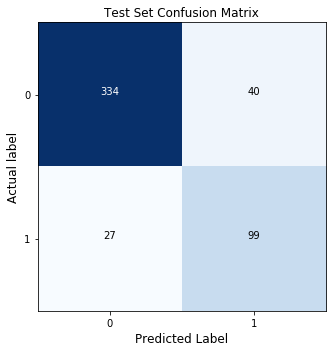

In [9]:
.util.displayCM[value .ml.confmat[telcoInputs`ytest;pred1];`0`1;"Test Set Confusion Matrix";()];

---

## Default NLP Configurations

The function `.automl.fit` can also be applied to textual data using its default configuration.

As with the example above, data must be presented with a 1-to-1 mapping between features and targets.

NLP (Natural Language Processing) specific feature extraction is then applied to any character columns within the data using NLP methods contained within the Kx [NLP Library](https://github.com/KxSystems/nlp), while normal feature extraction is applied to any remaining features.

### IMBD Dataset

The [IMBD](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) dataset contains reviews of over 50,000 movies for NLP or text analytics. The dataset consists of 2 columns, containing textual reviews and their associated positive or negative sentiment classification.

### Load NLP data

Below we load in 1500 rows of the IMDB dataset.

In [10]:
// load data
imdbData:1000#("SI";enlist ",")0:`:../data/IMBD.csv

// convert text data to string
imdbData:update string each comment from imdbData

// separate into feature and target data
imdbFeat:select comment from imdbData
imdbTarg:imdbData`tgt

// inspect data
-1"Shape of feature data is: ",(" x "sv string .ml.shape imdbFeat),"\n";
show 5#imdbFeat
-1"\nDistribution of target values:\n";
show update pcnt:.util.round[;.01]100*num%sum num from select num:count i by target from([]target:imdbTarg);

Shape of feature data is: 1000 x 1 x 585

comment                                                                        
-------------------------------------------------------------------------------
"If you like plot turns, this is your movie. It is impossible at any moment t..
"It's a real challenge to make a movie about a baby being devoured by wild ca..
"What a good film! Made Men is a great action movie with lots of twists and t..
"This is a movie that is bad in every imaginable way. Sure we like to know wh..
"There is something special about the Austrian movies not only by Seidl, but ..

Distribution of target values:

target| num pcnt
------| --------
0     | 477 47.7
1     | 523 52.3


We now split the data into training and testing sets to be used with `.automl.fit`

In [11]:
show imdbInputs:.ml.traintestsplit[imdbFeat;imdbTarg;.1]

xtrain| +(,`comment)!,("The creativeness of this movie was lost from the begi..
ytrain| 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 1 1 0..
xtest | +(,`comment)!,("I'm watching this on the Star World network overseas ..
ytest | 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 1 1..


### Inputs

The below example demonstrates a binary classification problem. Notice that this time `nlp` is being passed as the feature extraction type.

A slight modification will be made to the default parameters as this model will be saved under the name `nlpModelNotebook` and the overWriteFiles parameter will also be set to `1b` to allow users to run this notebook multiple times, overwriting the saved model each iteration.

In [12]:
IMBDfeats   :imdbInputs`xtrain                                              / features
IMBDtarget  :imdbInputs`ytrain                                              / targets
featureType2:`nlp                                                           / NLP feature extraction
problemType2:`class                                                         / classification problem
paramDict2  :`savedModelName`overWriteFiles`seed!(`nlpModelNotebook;1b;100) / define name of model

We can now run `automl.fit` utilizing the NLP functionality.

<div class="alert alert-danger">
<b>Warning</b>: Please allow ample time for the NLP configuration to run as feature extraction and hyperparameter search can take upwards of 5 minutes to complete.
</div>

In [13]:
start:.z.t
.automl.fit[IMBDfeats;IMBDtarget;featureType2;problemType2;paramDict2];
-1"\n.automl.fit took ",string .z.t-start;

Executing node: automlConfig
Executing node: configuration
Executing node: targetDataConfig
Executing node: targetData
Executing node: featureDataConfig
Executing node: featureData
Executing node: dataCheck

For full reproducibility between q processes of the NLP word2vec implementation, the PYTHONHASHSEED environment variable must be set upon initialization of q. See https://code.kx.com/q/ml/automl/ug/options/#seed for details.

Executing node: featureDescription

The following is a breakdown of information for each of the relevant columns in the dataset


       | count unique mean std min max type
-------| ----------------------------------
comment| 900   900    ::   ::  ::  ::  text


Executing node: dataPreprocessing

Data preprocessing complete, starting feature creation

Executing node: featureCreation
Executing node: labelEncode
Executing node: featureSignificance

Total number of significant features being passed to the models = 252

Executing node: trainTestSplit
Executing no

#### Feature impact

<img src="images/run2impact.png" />

From the above example, we can see that even though one feature was passed to the model, multiple features were created using the `nlp` feature creation methods. If there was any additional non textual data present, the `normal` feature creation procedures would of been applied to them. 

Looking at the feature impact above, we can see that the features created by the `word2vec` module (`colx`) were deemed to be the most important along with various features created from the NLP space library

#### Confusion matrix

<img src="images/run2conf.png" />

A confusion matrix is also produced within the pipeline for classification problems. We see that the final `RandomForestClassifier` model correctly classified 129 out of 180 data points. 

All other outputs from this run have been stored in a directory of format `/outputs/namedModels/modelName/`

### Test on new data

To retrieve a model, `.automl.getModel` can be used to extract the meta data and associated prediction function to be used on new data by passing the name or the date/time of the desired process

In [14]:
show model2:.automl.getModel[enlist[`savedModelName]!enlist "nlpModelNotebook"]

modelInfo| `modelLib`modelFunc`startDate`startTime`featureExtractionType`prob..
predict  | {[config;features]
  original_print:utils.printing;
  utils.printi..


The best model created within `automl.fit`  is applied to the unseen test data to evaluate the models performance

In [15]:
-1"Model applied to dataset:\n";
.util.printSavedModelId model2.modelInfo;
-1"\nPredictions: ";
show pred2:model2.predict[imdbInputs`xtest]
-1"\nTargets:";
show imdbInputs`ytest

Model applied to dataset:

Model Name: nlpModelNotebook.

Predictions: 
1 1 1 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1..

Targets:
1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1..


In [16]:
-1"Accuracy on model run using hold-out data: ",string accuracy2:.ml.accuracy[imdbInputs`ytest;pred2];

Accuracy on model run using hold-out data: 0.82


<Figure size 1440x108 with 0 Axes>

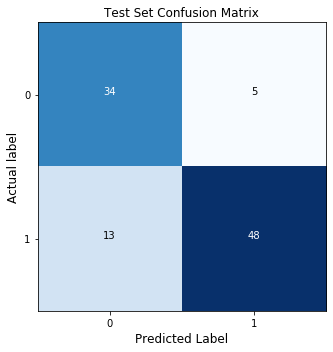

In [17]:
.util.displayCM[value .ml.confmat[imdbInputs`ytest;pred2];`0`1;"Test Set Confusion Matrix";()];

---

## Custom Configurations (Advanced)

In the previous section of the notebook, we showcased how to apply default parameters within the pipeline. In this section we will focus on how the final parameter of `.automl.fit` can be modified to apply changes to the default behaviour.

### Example 1

Below we apply `.automl.featureCreation.normal.truncSingleDecomp` to the data, this is a truncated singular value decomposition outlined [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) and applied to all combinations of columns of type float.

A random seed of `200` will also be set.

In [18]:
paramKeys:`seed`functions                                         // parameter names to amend
paramVals:(200;.automl.featureCreation.normal.truncSingleDecomp)  // amended values
show paramDict3:paramKeys!paramVals

seed     | 200
functions| {[features]
  truncCols:.ml.i.fndcols[features;"f"];
  truncCols@:..


In [19]:
start:.z.t
model3:.automl.fit[telcoInputs`xtrain;telcoInputs`ytrain;`normal;`class;paramDict3]
-1"\n.automl.fit took ",string .z.t-start;

Executing node: automlConfig
Executing node: configuration
Executing node: targetDataConfig
Executing node: targetData
Executing node: featureDataConfig
Executing node: featureData
Executing node: dataCheck
Executing node: featureDescription

The following is a breakdown of information for each of the relevant columns in the dataset


                | count unique mean     std      min   max     type       
------          | --------------------------------------------------------
tenure          | 4500  73     32.326   24.55931 0i    72i     numeric    
MonthlyCharges  | 4500  1251   64.88498 30.49795 18.55 118.75  numeric    
TotalCharges    | 4500  3178   2284.252 2275.078 18.85 8672.45 numeric    
customerID      | 4500  3310   ::       ::       ::    ::      categorical
gender          | 4500  2      ::       ::       ::    ::      categorical
Partner         | 4500  2      ::       ::       ::    ::      categorical
Dependents      | 4500  2      ::       ::       ::    ::      

<img src="images/run3impact.png" />

We can see by looking at the feature impact that many of the most impactful features are now derived from those generated when `.automl.featureCreation.normal.truncSingleDecomp` was applied during feature extraction, this gives some insight into the potential benefit of this form of feature extraction. 

While benefiting from increases in accuracy the addition of larger numbers of features can have the effect of slowing training time and scoring time which have have an impact in time critical use-cases.

We can now predict on the hold-out dataset in order to compare accuracy results to the default case.

In [20]:
-1"Model applied to dataset:\n";
.util.printDateTimeId model3.modelInfo;
-1"\nPredictions: ";
show pred3:model3.predict[telcoInputs`xtest]
-1"\nTargets:";
show telcoInputs`ytest

Model applied to dataset:

Model date: 2020.12.17. Model time: 13:21:58.841.

Predictions: 
0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0..

Targets:
0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0..


We can see that by adding feature extraction in the normal case, we have improved the accuracy slightly increases. This is highlighted in the confusion matrix below.

In [21]:
.util.printDateTimeId model1.modelInfo;
-1"Accuracy on default model run using held-out data: ",string[accuracy1],"\n";
.util.printDateTimeId model3.modelInfo;
-1"Accuracy on custom model run using held-out data : ",string .ml.accuracy[telcoInputs`ytest;pred3];

Model date: 2020.12.17. Model time: 13:19:02.184.
Accuracy on default model run using held-out data: 0.866

Model date: 2020.12.17. Model time: 13:21:58.841.
Accuracy on custom model run using held-out data : 0.858


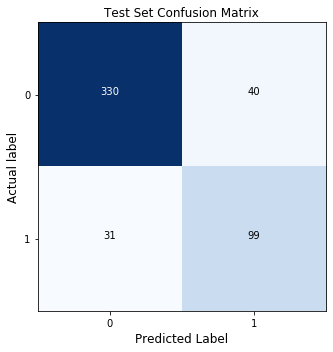

In [22]:
.util.displayCM[value .ml.confmat[telcoInputs`ytest;pred3];`0`1;"Test Set Confusion Matrix";()];

### Example 2

In this example we again use the Telco dataset and highlight how to change the save options contained under `saveOption` within the parameter dictionary.

In the default case, not modified in the examples above, the system will save all outputs to disk (reports, images, config file and models). Below we will set the `saveOption` to be `0`, which means that the results will be displayed to console but nothing is persisted to disk.

Other alterations made to the `paramDict` in the below model were
1. Added a **random seed**: Here we have altered the ``` `seed``` parameter to be `175`.
2. Changed the size of the **holdout** sets to be 30% of the data at each stage.
3. Changed the **hyperparameter search** type from the default of grid search to random search and set the number of repetitions to `2`. Note that Sobol-random search is also available.

A smaller subset of 1000 datapoints will be used

In [23]:
\S 42
features:1000?telcoFeat
target  :1000?telcoTarg

paramKeys:`saveOption`seed`holdoutSize`hyperparameterSearchType`randomSearchArgument // parameter names to amend
paramVals:(0;175;.3;`random;2)                                                       // amended values
show paramDict:paramKeys!paramVals

saveOption              | 0
seed                    | 175
holdoutSize             | 0.3
hyperparameterSearchType| `random
randomSearchArgument    | 2


In [24]:
.automl.fit[features;target;`normal;`class;paramDict];

Executing node: automlConfig
Executing node: configuration
Executing node: targetDataConfig
Executing node: targetData
Executing node: featureDataConfig
Executing node: featureData
Executing node: dataCheck
Executing node: featureDescription

The following is a breakdown of information for each of the relevant columns in the dataset


                | count unique mean     std      min   max     type       
------          | --------------------------------------------------------
tenure          | 1000  73     33.551   25.0546  0i    72i     numeric    
MonthlyCharges  | 1000  582    64.02735 30.38511 18.8  118.75  numeric    
TotalCharges    | 1000  834    2358.61  2345.948 18.85 8672.45 numeric    
customerID      | 1000  842    ::       ::       ::    ::      categorical
gender          | 1000  2      ::       ::       ::    ::      categorical
Partner         | 1000  2      ::       ::       ::    ::      categorical
Dependents      | 1000  2      ::       ::       ::    ::      

As we can see compared to the previous default behaviour nothing has been saved down during a single run of the pipeline.

### Example 3

In this example, the IMDB dataset is used with the following changes made to the input dictionary `paramDict`:

1. **Word2vec transformation** changed from default `continuous bag of words` method to `skip-gram`.
2. **Significant feature function** changed to use the percentile based procedure.
3. **Random seed** set as `275`.

In this example, printing to screen will also be suppressed and redirected to a log file called `LogFile`

In [25]:
.automl.updatePrinting[]   // Disable printing to screen 
.automl.updateLogging[]    // Redirect printing to log file


// new significant feature function 
.automl.newSigFeat:{[x;y]
  .ml.fresh.significantfeatures[x;y;.ml.fresh.percentile 0.10]
  }

// new parameter dictionary
paramKeys:`significantFeatures`w2v`seed`loggingFile  // parameter names to amend
paramVals:(`.automl.newSigFeat;1;275;"logFile")      // amended values
show paramDict4:paramKeys!paramVals

significantFeatures| `.automl.newSigFeat
w2v                | 1
seed               | 275
loggingFile        | "logFile"


In [26]:
// run automl with new parameters
model4:.automl.fit[imdbInputs`xtrain;imdbInputs`ytrain;`nlp;`class;paramDict4]

Executing node: automlConfig
Executing node: configuration
Executing node: targetDataConfig
Executing node: targetData
Executing node: featureDataConfig
Executing node: featureData
Executing node: dataCheck
Executing node: featureDescription
Executing node: dataPreprocessing
Executing node: featureCreation
Executing node: labelEncode
Executing node: featureSignificance
Executing node: trainTestSplit
Executing node: modelGeneration
Executing node: selectModels
Executing node: runModels
Executing node: optimizeModels
Executing node: predictParams
Executing node: preprocParams
Executing node: pathConstruct
Executing node: saveGraph
Executing node: saveReport
Executing node: saveMeta
Executing node: saveModels


We can see that the features deemed important compared with the initial run have varied. In this iteration, very few of the features created from the NLP spacy libraru were deemed to be significant when predicting the target value

<img src="images/run4impact.png" />

In [27]:
.util.printDateTimeId model4.modelInfo;
-1"\nPredictions: ";
show pred4:model4.predict[imdbInputs`xtest]
-1"\nTargets:";
show imdbInputs`ytest

Model date: 2020.12.17. Model time: 13:29:05.671.

Predictions: 
1 1 1 1 0 1 1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1..

Targets:
1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1..


Below we can see how changing the `w2v` implementation decreased the accuracy of the model compared with the initial run

In [28]:
.util.printDateTimeId model2.modelInfo;
-1"Accuracy on default model run using held-out data: ",string[accuracy2],"\n";
.util.printDateTimeId model4.modelInfo;
-1"Accuracy on custom model run using held-out data : ",string .ml.accuracy[imdbInputs`ytest;pred4];

Model date: 2020.12.17. Model time: 13:20:21.758.
Accuracy on default model run using held-out data: 0.82

Model date: 2020.12.17. Model time: 13:29:05.671.
Accuracy on custom model run using held-out data : 0.73


---